# Klasyfikacja ręcznie pisanych cyfr za pomocą CNN oraz Gradient Boosting

## Biblioteki oraz zestaw danych

In [ ]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from itertools import tee
%matplotlib inline
import matplotlib.pyplot as plt                         # Wykresy
import numpy as np                                      # Macierze i typy
from sklearn import datasets                            # Wczytywanie zestawu danych
from sklearn.ensemble import GradientBoostingClassifier # Algorytm gradient boosting
from sklearn.metrics import classification_report       # Obliczanie błędu modelu
from sklearn.utils import shuffle                       # Randomizowanie zestawu danych

# biblioteki do CNN 
import tensorflow as tf
import keras                                            
from keras.utils import np_utils

# wczytanie zestawu danych MNIST
from keras.datasets import mnist

# rodzaj modelu
from keras.models import Sequential

# warstwy sieci neuronowej
from keras.layers import Conv2D, MaxPooling2D        
from keras.layers import Flatten, Dense, Dropout

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# TODO: wczytać MNIST, a nie ten uproszczony zbiór
digits = datasets.load_digits()

In [3]:
def pairwise(iterable):
    """s -> (s0,s1), (s1,s2), (s2, s3), ..."""
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

## Analiza danych

In [4]:
print("Zbiór danych składa się z", digits.data.shape[0], "instancji.")

Zbiór danych składa się z 1797 instancji.


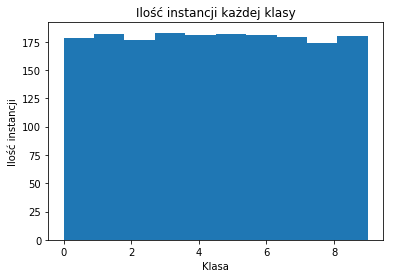

In [5]:
plt.title("Ilość instancji każdej klasy")
plt.xlabel("Klasa")
plt.ylabel("Ilość instancji")
_ = plt.hist(digits.target, bins=len(digits.target_names))

In [6]:
print("Każda instancja posiada", digits.data.shape[1], "cechy.")

Każda instancja posiada 64 cechy.


Zestaw danych składa się z obrazów 8 x 8 px, przedstawiających ręcznie pisane cyfry.
Poniżej zaprezentowana jest pierwsza instancja zestawu.

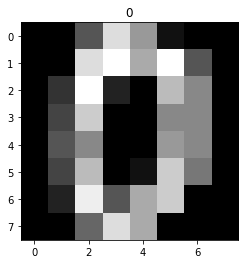

In [ ]:
plt.title(digits.target[0])
_ = plt.imshow(np.reshape(digits.data[0], (8, 8)), cmap='gray')

Wg, żródła[^1], większość ludzi preferuje oglądać obrazy rozmazane zamiast obrazów w małej rozdzielczości.
W związku z tym, od tego momentu przy wyświetlaniu obrazów posłużymy się interpolacją.

[^1]: https://matplotlib.org/users/image_tutorial.html 

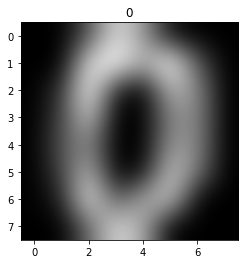

In [8]:
plt.title(digits.target[0])
_ = plt.imshow(np.reshape(digits.data[0], (8, 8)), cmap='gray', interpolation='bicubic')

Aby zapoznać czytelnika z zestawem danych, poniżej prezentujemy jeszcze kilka instancji różnych klas.

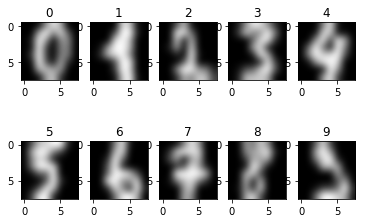

In [9]:
for idx in range(0, 10):
    instance_no = 10 + idx
    plt.subplot(2, 5, 1 + idx)
    plt.title(digits.target[instance_no])
    _ = plt.imshow(np.reshape(digits.data[instance_no], (8, 8)), cmap='gray', interpolation='bicubic')

## Przygotowanie danych do procesu uczenia

Przygotowanie danych do procesu uczenia rozpoczęliśmy od randomizacji zestawu.

In [10]:
x, y = shuffle(digits.data, digits.target, random_state=13)

Aby podczas procesu walidacji modelu dokonać k-krotnej walidacji krzyżowej, podzieliliśmy zestaw na k podzbiorów.

In [11]:
k = 10

split_points = np.linspace(0, digits.data.shape[0], k + 1, dtype=int)

x_subsets = [x[start:end] for start, end in pairwise(split_points)]
y_subsets = [y[start:end] for start, end in pairwise(split_points)]

## Budowanie modelu

In [12]:
classifiers = [None] * k

with ProcessPoolExecutor() as executor:
    def fit(idx):
        classifier = GradientBoostingClassifier()
        classifier.fit(
            np.concatenate(x_subsets[:idx] + x_subsets[idx+1:]),
            np.concatenate(y_subsets[:idx] + y_subsets[idx+1:]),
        )
        return classifier
    
    future_to_classifier = {executor.submit(fit, idx): idx for idx in range(k)}
    
    for future in as_completed(future_to_classifier):
        idx = future_to_classifier[future]
        classifiers[idx] = future.result()
        

### Ewaluacja modelu

In [13]:
y_true = y
y_pred = np.concatenate([classifier.predict(x_test) for classifier, x_test in zip(classifiers, x_subsets)])
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       178
           1       0.95      0.98      0.96       182
           2       0.99      0.97      0.98       177
           3       0.99      0.94      0.96       183
           4       0.99      0.98      0.99       181
           5       0.97      0.95      0.96       182
           6       0.99      0.97      0.98       181
           7       0.97      0.98      0.97       179
           8       0.90      0.98      0.94       174
           9       0.93      0.95      0.94       180

   micro avg       0.97      0.97      0.97      1797
   macro avg       0.97      0.97      0.97      1797
weighted avg       0.97      0.97      0.97      1797



## Użycie modelu w praktyce

In [15]:
classifier = GradientBoostingClassifier()
_ = classifier.fit(x, y)

## Podsumowanie